In [1]:
import numpy as np
import matplotlib.pyplot as plt


#set random seed of numpy
np.random.seed(1995)

### DATA GENERATION

We sample random ground-truth concepts from the $[0,1]$ interval. 
We get $N$ samples $c \sim \mathrm{Unif}([0,1])$.  

The labels are determined by considering a random matrix $W$ applied to the first four concept components. 
Formally, we have: \
$$ y \leftarrow \arg\max_y \, W_y c_{1:4} $$ 
where it returns $0$ or $1$ based on the magnitude of the logits  $  W_y c_{1:4}$. 

In [2]:
# generate ground-truth concepts & labels

N = 10000
ndim = 16
G = np.random.uniform(-1,1, (N,ndim))

W = np.random.normal(loc=0, scale=5, size=(4,2))
# b = np.random.normal(loc=0, scale=2, size=(1,10))

Y = np.argmax(
          np.matmul(G[:,:4], W),
      axis=1)


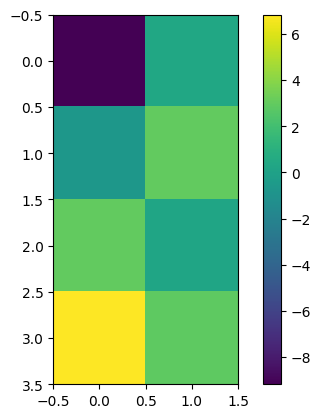

In [3]:
plt.imshow(W)
plt.colorbar()
plt.show()

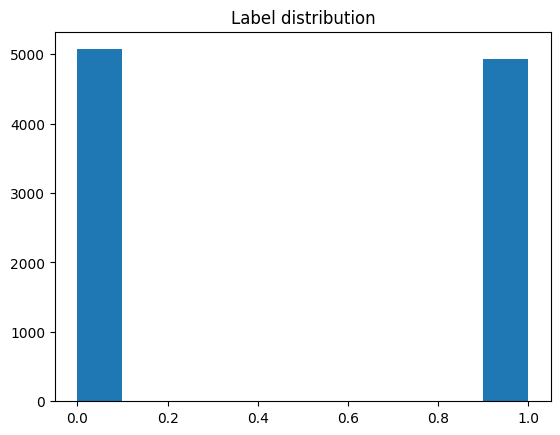

In [4]:
plt.hist(Y, bins=10)
plt.title('Label distribution')
plt.show()

In [5]:
## SCORING BASED ON CORRELATIONS

from scipy.stats import spearmanr

ranks = []
for i in range(16):
  r = spearmanr(G[:,i], Y)
  print(
      'Rank for the concept #', i, ':',
      r
  )
  ranks.append(np.abs(r[0]))

np.argsort(ranks)

Rank for the concept # 0 : SignificanceResult(statistic=0.7518805365584489, pvalue=0.0)
Rank for the concept # 1 : SignificanceResult(statistic=0.20626228784258505, pvalue=1.582301909471778e-96)
Rank for the concept # 2 : SignificanceResult(statistic=-0.17204480670484865, pvalue=2.7115329852028692e-67)
Rank for the concept # 3 : SignificanceResult(statistic=-0.24879819283375854, pvalue=5.993064111548234e-141)
Rank for the concept # 4 : SignificanceResult(statistic=0.006800682542880058, pvalue=0.4965100941791982)
Rank for the concept # 5 : SignificanceResult(statistic=0.01283728043182291, pvalue=0.19927478914583677)
Rank for the concept # 6 : SignificanceResult(statistic=-0.014452199591135037, pvalue=0.1484256536617642)
Rank for the concept # 7 : SignificanceResult(statistic=0.010345924474718745, pvalue=0.30090677573373814)
Rank for the concept # 8 : SignificanceResult(statistic=0.007883115593327307, pvalue=0.43056495580273346)
Rank for the concept # 9 : SignificanceResult(statistic=-0.

array([ 9, 10, 13,  4,  8, 15,  7, 12, 14,  5,  6, 11,  2,  1,  3,  0])

## VARIATIONS ON C's

We investigate how leakage is measured based on perturbation on ground-truths to generate model concepts. \
We first define the leakage test and the leakage measure used in the paper.

In [6]:
## LEAKAGE TEST MEASURE

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split


def leakage_test(ranks, C, G, Y):
  sorting = np.argsort(ranks)

  #perform train/test split
  C_train, C_test, G_train, G_test, Y_train, Y_test = train_test_split(C, G, Y, test_size=0.2)

  comps = []
  gaps = []
  scores = []
  for i in range(len(sorting)):
    comps.append(sorting[i])

    newG_train = G_train[:, comps]
    newG_test = G_test[:, comps]

    newC_train = C_train[:, comps]
    newC_test = C_test[:, comps]

    clf1 = SVC(kernel='linear')
    clf1.fit(newG_train, Y_train)

    clf2 = SVC(kernel='linear')
    clf2.fit(newC_train, Y_train)

    f1_GT   = f1_score(Y_test, clf1.predict(newG_test), average='macro')
    f1_pred = f1_score(Y_test, clf2.predict(newC_test), average='macro')

    scores.append((f1_GT, f1_pred))
    gaps.append(f1_pred - f1_GT)

  return gaps, scores

def leakage_measure(gaps,scores):
  score, Z = 0, 0
  for i in range(len(gaps)):
    Z += scores[i][0]
    if gaps[i] > 0:
      score += gaps[i]

  score /= len(gaps)*(1 - Z/len(gaps))
  return score


### RANDOM CONCEPTS

We generate random concepts by sampling from the same distribution of the ground-truths. \
In this case, $c  \sim \mathrm{Unif} ([0,1]) $. 

Leakage score: 0.020830765223622788


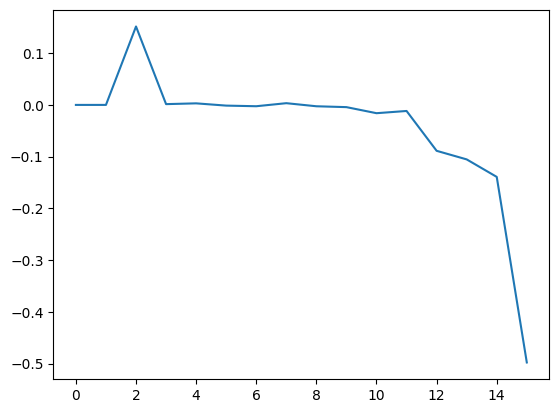

In [7]:
# RANDOM CONCEPTS

C = np.random.uniform(-1,1, (N,ndim))
gaps, scores = leakage_test(ranks, C, G, Y)
print('Leakage score:', leakage_measure(gaps, scores))

gaps_random = gaps

plt.plot(range(ndim), gaps)
plt.show()

### CONCEPTS FROM GT WITH INCREASING AMOUNT OF NOISE

We consider ground-truth concepts and add noise to them: \
$\hat c = c + \eta $ \
where $\eta$ is a Gaussian Noise.

Leakage score: 0.00038254716365878667


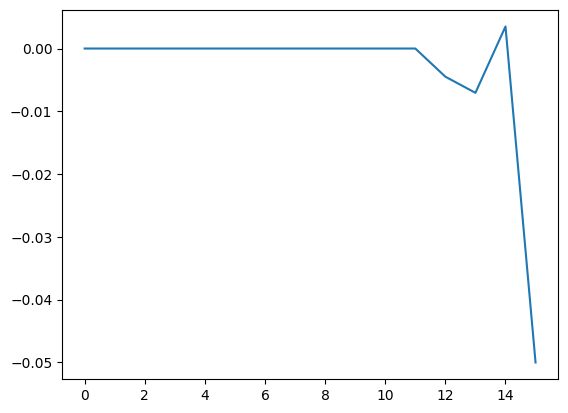

In [8]:
noise = 0.1

C = G + np.random.normal(0, noise, G.shape)
gaps, scores = leakage_test(ranks, C, G, Y)
print('Leakage score:', leakage_measure(gaps, scores))

gaps_noise_01 = gaps

plt.plot(range(ndim), gaps)
plt.show()

Leakage score: 0.00810326781050978


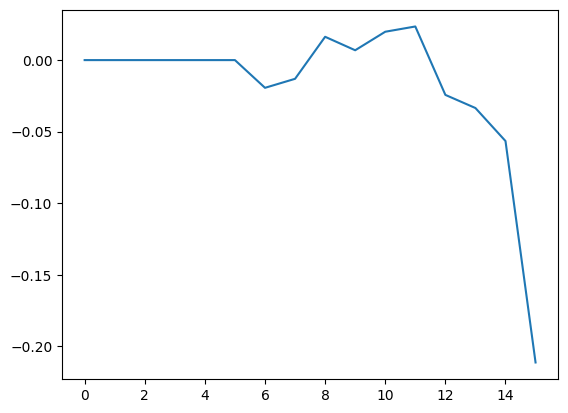

In [9]:
noise = 0.5

C = G + np.random.normal(0, noise, G.shape)
gaps, scores = leakage_test(ranks, C, G, Y)
print('Leakage score:', leakage_measure(gaps, scores))

gaps_noise_05 = gaps

plt.plot(range(ndim), gaps)
plt.show()

Leakage score: 0.0


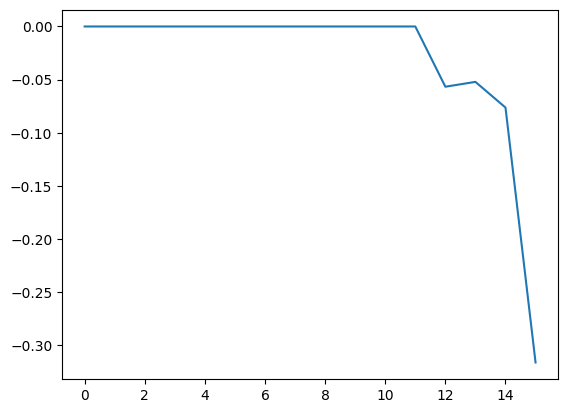

In [10]:
noise = 1

C = G + np.random.normal(0, noise, G.shape)
gaps, scores = leakage_test(ranks, C, G, Y)
print('Leakage score:', leakage_measure(gaps, scores))

gaps_noise_10 = gaps

plt.plot(range(ndim), gaps)
plt.show()

### CONCEPTS WITH LABEL INFORMATION AND NOISE

We create model concepts by encoding the value of the label and adding white noise: \
$ \hat c = 2 (y - 1) + \eta  $ \
where $\eta$ is Gaussian Noise.

S-rank correlation: 0.24873860427765915
S-rank correlation: 0.23013152332347558
S-rank correlation: 0.2345291587636104
S-rank correlation: 0.24691588735120512
S-rank correlation: 0.25263139992739847
S-rank correlation: 0.23400457160287963
S-rank correlation: 0.24538951955781738
S-rank correlation: 0.2465599496620393
S-rank correlation: 0.23627995368863286
S-rank correlation: 0.2347879532485304
S-rank correlation: 0.2454331023505924
S-rank correlation: 0.26576839000969565
S-rank correlation: 0.24115817776261111
S-rank correlation: 0.2439607107027878
S-rank correlation: 0.2326373606854923
S-rank correlation: 0.25251152992501247
Leakage score: 0.5768119953490877


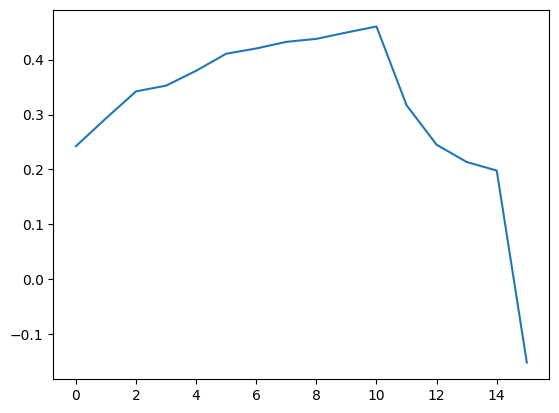

In [11]:
# high noise

noise = 4
C = np.random.normal(0, noise, (N,ndim))

for i in range(ndim):
  C[:,i] += 2*(Y)-1

  print(
      'S-rank correlation:', spearmanr(C[:,i], Y)[0]
  )

gaps, scores = leakage_test(ranks, C, G, Y)
print('Leakage score:', leakage_measure(gaps, scores))

gaps_leak_10 = gaps

plt.plot(range(ndim), gaps)
plt.show()

S-rank correlation: 0.3239444894624717
S-rank correlation: 0.31253958627014244
S-rank correlation: 0.31035372559657576
S-rank correlation: 0.31979636377874837
S-rank correlation: 0.30733667385444136
S-rank correlation: 0.31489402712625547
S-rank correlation: 0.327452176746164
S-rank correlation: 0.32200287257989374
S-rank correlation: 0.3220461089275752
S-rank correlation: 0.32500502718300334
S-rank correlation: 0.31413108574112714
S-rank correlation: 0.3035416450101162
S-rank correlation: 0.3095607820663416
S-rank correlation: 0.3158439795729097
S-rank correlation: 0.3113284142229131
S-rank correlation: 0.32389044402786993
Leakage score: 0.6652420852735859


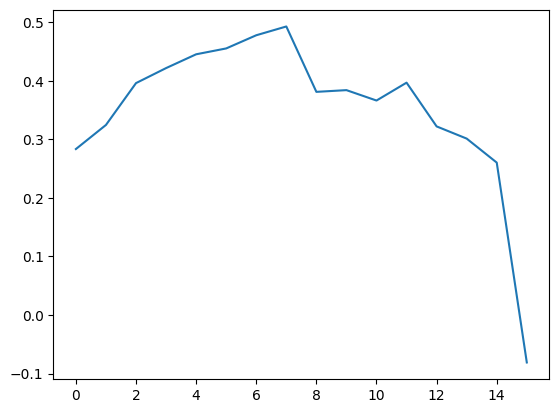

In [12]:
noise = 3
C = np.random.normal(0, noise, (N,ndim))

for i in range(ndim):
  C[:,i] += 2*(Y)-1

  print(
      'S-rank correlation:', spearmanr(C[:,i], Y)[0]
  )

gaps, scores = leakage_test(ranks, C, G, Y)
print('Leakage score:', leakage_measure(gaps, scores))

gaps_leak_075 = gaps

plt.plot(range(ndim), gaps)
plt.show()

S-rank correlation: 0.4448824434939839
S-rank correlation: 0.45686348487697176
S-rank correlation: 0.44899169803820527
S-rank correlation: 0.4563525476529289
S-rank correlation: 0.4449828432821096
S-rank correlation: 0.46479104937580806
S-rank correlation: 0.4637736787139391
S-rank correlation: 0.4575624724978213
S-rank correlation: 0.4571348899632989
S-rank correlation: 0.4553919246973918
S-rank correlation: 0.46057772272546904
S-rank correlation: 0.44894368074823215
S-rank correlation: 0.4509888847137968
S-rank correlation: 0.467242356280092
S-rank correlation: 0.442187724266936
S-rank correlation: 0.44146358473229097
Leakage score: 0.7771914498084619


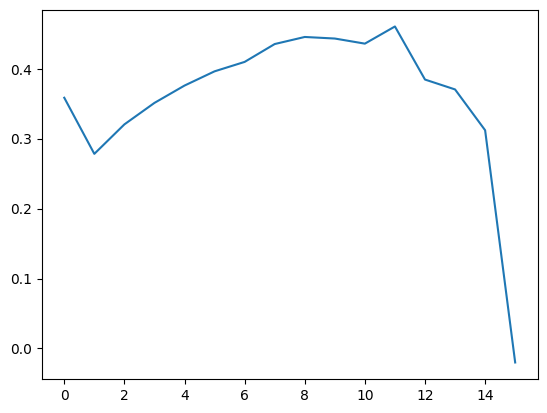

In [13]:
noise = 2
C = np.random.normal(0, noise, (N,ndim))

for i in range(ndim):
  C[:,i] += 2*(Y)-1

  print(
      'S-rank correlation:', spearmanr(C[:,i], Y)[0]
  )

gaps, scores = leakage_test(ranks, C, G, Y)
print('Leakage score:', leakage_measure(gaps, scores))

gaps_leak_05 = gaps

plt.plot(range(ndim), gaps)
plt.show()

S-rank correlation: 0.7261115347622874
S-rank correlation: 0.7300723029393913
S-rank correlation: 0.7275435309121782
S-rank correlation: 0.715363491467426
S-rank correlation: 0.7199734977499381
S-rank correlation: 0.7250049198443068
S-rank correlation: 0.7229061554672715
S-rank correlation: 0.7264422512486389
S-rank correlation: 0.7278136887961684
S-rank correlation: 0.7339510329183303
S-rank correlation: 0.725035545590581
S-rank correlation: 0.7320755177596115
S-rank correlation: 0.7190396203556271
S-rank correlation: 0.7296431267574383
S-rank correlation: 0.7326438262911547
S-rank correlation: 0.7307868113004342
Leakage score: 0.9618823803372948


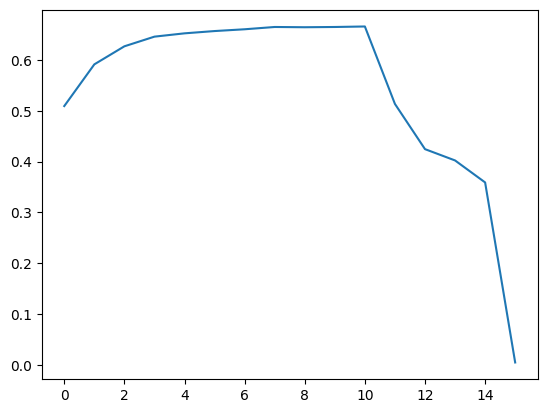

In [14]:
noise = 1
C = np.random.normal(0, noise, (N,ndim))

for i in range(ndim):
  C[:,i] += 2*(Y)-1

  print(
      'S-rank correlation:', spearmanr(C[:,i], Y)[0]
  )

gaps, scores = leakage_test(ranks, C, G, Y)
print('Leakage score:', leakage_measure(gaps, scores))

gaps_leak_025 = gaps

plt.plot(range(ndim), gaps)
plt.show()

### ENTANGLED CONCEPTS

We create entangled variants by using: \
$ \hat c = O \hat c $ \
where $O$ is a randomly generated matrix.  

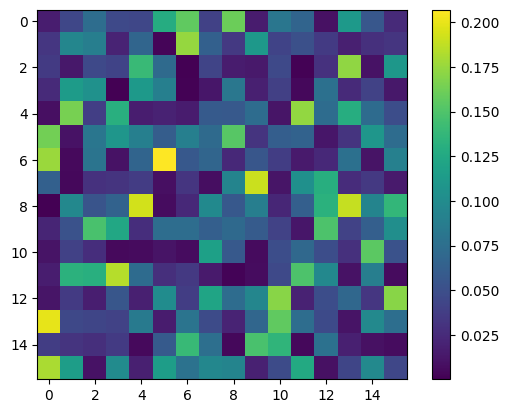

In [15]:
O = np.random.normal(loc=0, scale=5, size=(ndim, ndim))


plt.imshow(np.abs(O)/np.sum(np.abs(O), axis=0, keepdims=True))
plt.colorbar()
plt.show()

In [16]:
ent_frac = 1
C = (1-ent_frac)*np.copy(G) + ent_frac*np.matmul(
    np.copy(G), 
    O)

gaps, scores = leakage_test(ranks, C, G, Y)
print('Leakage score:', leakage_measure(gaps, scores))

gaps_ent_100 = gaps

# plt.plot(range(ndim), gaps)
# plt.show()

Leakage score: 0.5805414438642867


Leakage score: 0.5996193531133247


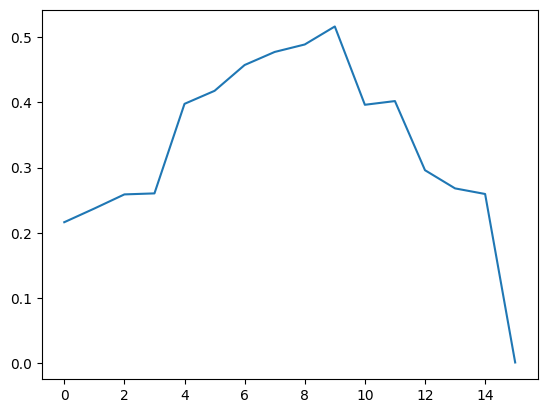

In [17]:
ent_frac = 0.75
C = (1-ent_frac)*np.copy(G) + ent_frac*np.matmul(
    np.copy(G), 
    O)

gaps, scores = leakage_test(ranks, C, G, Y)
print('Leakage score:', leakage_measure(gaps, scores))

gaps_ent_75 = gaps

plt.plot(range(ndim), gaps)
plt.show()

Leakage score: 0.5778455117889315


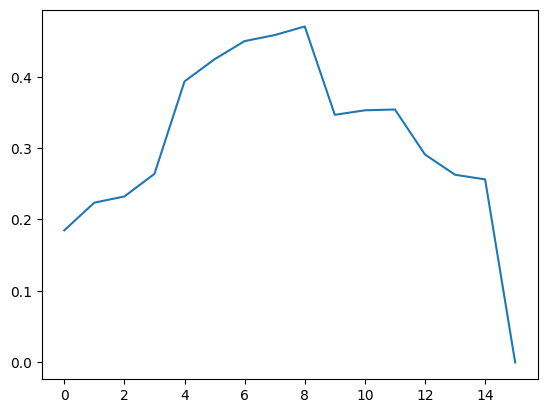

In [18]:
ent_frac = 0.5
C = (1-ent_frac)*np.copy(G) + ent_frac*np.matmul(
    np.copy(G), 
    O)

gaps, scores = leakage_test(ranks, C, G, Y)
print('Leakage score:', leakage_measure(gaps, scores))

gaps_ent_50 = gaps

plt.plot(range(ndim), gaps)
plt.show()

Leakage score: 0.5884653157398098


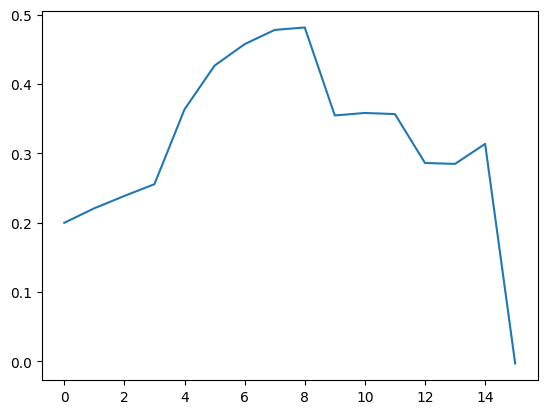

In [19]:
ent_frac = 0.25
C = (1-ent_frac)*np.copy(G) + ent_frac*np.matmul(
    np.copy(G), 
    O)

gaps, scores = leakage_test(ranks, C, G, Y)
print('Leakage score:', leakage_measure(gaps, scores))

gaps_ent_25 = gaps

plt.plot(range(ndim), gaps)
plt.show()

### NOW WE HAVE EVERYTHING READY TO GENERATE THE GAPS PLOT

We simply combine all gaps from previous runs using `matplotlib`

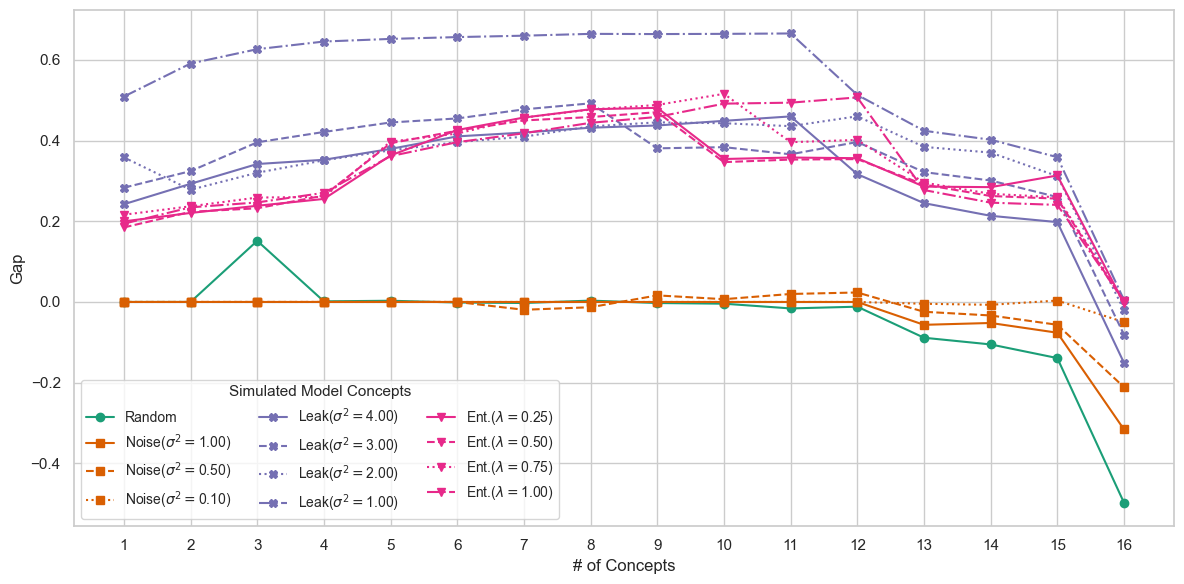

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set(style='whitegrid')

# Define plot figure
fig = plt.figure(figsize=(12, 6))

# Define x-axis
x = range(ndim)

# Custom Seaborn color palette
palette = sns.color_palette("Dark2", 6)

# Plot each group with consistent style
plt.plot(x, gaps_random, label='Random', marker='o', linestyle='-', color=palette[0])

# Noise
# plt.plot(x, gaps_noise_01, label='Noise($\sigma=$0.10)', marker='s', linestyle='-', color=palette[1])
plt.plot(x, gaps_noise_10, label='Noise($\sigma^2=$1.00)', marker='s', linestyle='-', color=palette[1])
plt.plot(x, gaps_noise_05, label='Noise($\sigma^2=$0.50)', marker='s', linestyle='--', color=palette[1])
plt.plot(x, gaps_noise_01, label='Noise($\sigma^2=$0.10)', marker='s', linestyle=':', color=palette[1])

# Leak
plt.plot(x, gaps_leak_10,  label='Leak($\sigma^2=$4.00)', marker='X', linestyle='-', color=palette[2])
plt.plot(x, gaps_leak_075, label='Leak($\sigma^2=$3.00)', marker='X', linestyle='--', color=palette[2])
plt.plot(x, gaps_leak_05,  label='Leak($\sigma^2=$2.00)', marker='X', linestyle=':', color=palette[2])
plt.plot(x, gaps_leak_025, label='Leak($\sigma^2=$1.00)', marker='X', linestyle='-.', color=palette[2])

# Entropy
plt.plot(x, gaps_ent_25, label='Ent.($\lambda=$0.25)', marker='v', linestyle='-', color=palette[3])
plt.plot(x, gaps_ent_50, label='Ent.($\lambda=$0.50)', marker='v', linestyle='--', color=palette[3])
plt.plot(x, gaps_ent_75, label='Ent.($\lambda=$0.75)', marker='v', linestyle=':', color=palette[3])
plt.plot(x, gaps_ent_100, label='Ent.($\lambda=$1.00)', marker='v', linestyle='-.', color=palette[3])

# Joint
# plt.plot(x, gaps_joint_00,  label='Ent+Leak($\lambda=$0.00)', marker='^', linestyle='-', color=palette[4])
# plt.plot(x, gaps_joint_33,  label='Ent+Leak($\lambda=$0.33)', marker='^', linestyle='--', color=palette[4])
# plt.plot(x, gaps_joint_66,  label='Ent+Leak($\lambda=$0.66)', marker='^', linestyle=':', color=palette[4])
# plt.plot(x, gaps_joint_100, label='Ent+Leak($\lambda=$1.00)', marker='^', linestyle='-.', color=palette[4])

# Labels and ticks
plt.xlabel('# of Concepts', fontsize=12)
plt.ylabel('Gap', fontsize=12)
plt.xticks(ticks=x, labels=[str(i + 1) for i in x])

# Better legend
plt.legend(title='Simulated Model Concepts', ncol=3, fontsize=10, title_fontsize=11)

# Tight layout and show
plt.tight_layout()

plt.savefig('sanity-checks-v4.png')

plt.show()

